# WEAT and RIPA evaluation of embeddings

In [2]:
import bz2
import pandas as pd
import numpy as np
print("hej")
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


hej


In [3]:
import ipykernel
print(ipykernel.__version__)
import IPython
print(IPython.__version__)
import sys
print(sys.version)

6.8.0
8.0.1
3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0]


## Importing datasets
Importing the large set of vectors might take a little while, please be patient.

In [4]:
colnames = ["word"] + ["dim" + str(x) for x in range(1,301)]

with bz2.open("swectors.txt.bz2") as source:
    swectors = pd.read_csv(source, header=None, names=colnames, delimiter=" ", skiprows=[0])
    
familjevectors = pd.read_csv("familjevectors.zip", header=None, names=colnames, delimiter=" ", skiprows=[0])

flashvectors = pd.read_csv("flashvectors.zip", header=None, names=colnames, delimiter=" ", skiprows=[0])
    
#swectors.tail()

In [5]:
def get_word_vector(vectors, word):
    return vectors.loc[vectors['word'] == word].loc[:, 'dim1':'dim300'].to_numpy()[0]

In [6]:
def cossim(vec1, vec2):
    return np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

In [7]:
def WEAT(test_vector, male_attribute_vectors:list, female_attribute_vectors:list):
    # Negative result indicate female association
    # Positive result indicate male association
    sumMale = 0
    sumFemale = 0
    for male_vector, female_vector in zip(male_attribute_vectors, female_attribute_vectors):
        sumMale += cossim(test_vector, male_vector)
        sumFemale += cossim(test_vector, female_vector)
    meanMale = sumMale / len(male_attribute_vectors)
    meanFemale = sumFemale / len(female_attribute_vectors)
    return meanMale - meanFemale

def test_statistics(X_target_words, Y_target_words, male_attribute_vectors, female_attribute_vectors):
   sumX = 0
   sumY = 0
   for x, y in zip(X_target_words, Y_target_words):
       sumX += WEAT(x, male_attribute_vectors, female_attribute_vectors)
       sumY += WEAT(y, male_attribute_vectors, female_attribute_vectors)
  
   return sumX - sumY

In [23]:
female_attribute_words = [
    "kvinnor", 
    "kvinnlig", 
    "tjej", 
    "drottning", 
    "kvinnan"
]

male_attribute_words = [
    "män", 
    "manlig", 
    "kille", 
    "kung", 
    "mannen"
]

target_words_possibly_male = [
    "programmerare",
    "rörmokare",
    "lastbilschaufför",
    "ingenjör",
    "han",
    "prins"
]

target_words_possibly_female = [
    "sjuksköterska",
    "förskollärare",
    "bibliotekarie",
    "receptionist",
    "hon",
    "prinsessa"
]

target_words_possibly_neutral = [
    "politiker",
    "optiker",
    "förälder",
    "försäljare",
    "stol",
    "moln",
    "böcker",
    "neutral",
    "folk"
]

female_attribute_words_alt = [
    "tjejer", 
    "damer", 
    "kvinnornas", 
    "princessa", 
    "flickan"
]

male_attribute_words_alt = [
    "killar", 
    "herrar", 
    "männens", 
    "prins", 
    "pojken"
]

def get_words_and_vectors(words, embeddings):
    return [(word, get_word_vector(embeddings, word)) for word in words]

def get_vectors(words, embeddings):
    return [get_word_vector(embeddings, word) for word in words]

In [25]:
def get_gender_diff_vectors(embeddings, alt=False):
    v = []
    if alt:
        for male_word, female_word in zip(male_attribute_words_alt, female_attribute_words_alt):
            v.append(get_word_vector(embeddings, male_word) - get_word_vector(embeddings, female_word))
    else:
        for male_word, female_word in zip(male_attribute_words, female_attribute_words):
            v.append(get_word_vector(embeddings, male_word) - get_word_vector(embeddings, female_word))
    return v
    

def get_first_pc(vecs):
    pca = PCA(n_components=1)
    pca.fit(vecs)
    return pca.components_


def RIPA(embeddings, test_string, alt=False):
    """
    Positive RIPA values indicate male association and negative RIPA values indicate female association
    """
    gender_diff_vectors = get_gender_diff_vectors(embeddings, alt)

    test_word = get_word_vector(embeddings, test_string)
    b = get_first_pc(gender_diff_vectors)[0]
    #return cossim(b, test_word)
    return np.dot(b, test_word) # the real measuring
    

In [11]:
print(RIPA(swectors, "ingenjör"))
print(RIPA(familjevectors, "ingenjör"))
print(RIPA(flashvectors, "ingenjör"))

print(RIPA(swectors, "sjuksköterska"))
print(RIPA(familjevectors, "sjuksköterska"))
print(RIPA(flashvectors, "sjuksköterska"))

0.05919479376616162
0.04272516449718714
0.01487462742583406
-0.16572209542851485
0.05951412967418781
-0.10414158062203034


300


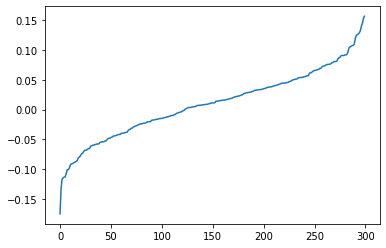

In [12]:
b = get_first_pc(get_gender_diff_vectors(swectors))[0]
print(len(b))
b.sort()
plt.plot(b)
plt.show()

In [13]:

weat_values = {"swectors": [], "flashvectors": [], "familjevectors": []}
ripa_values = {"swectors": [], "flashvectors": [], "familjevectors": []}

target_words = target_words_possibly_male + target_words_possibly_female + target_words_possibly_neutral

print(f"{' '.ljust(20)}Swectors\t\t\t\tFlashback\t\t\tFamiljeliv\n")
print(f"{'Word'.ljust(20)}WEAT\t\tRIPA\t\tWEAT\t\tRIPA\t\tWEAT\t\tRIPA\n")

for word in target_words:
    data = {}
    for name, embeddings in [("swectors", swectors), ("flashvectors", flashvectors), ("familjevectors", familjevectors)]:
        female_attribute_words_vectors = get_vectors(female_attribute_words, embeddings)
        male_attribute_words_vectors = get_vectors(male_attribute_words, embeddings)

        try:
            word_vector = get_word_vector(embeddings, word)
        except Exception as e:
            print(word)
            continue
        weat = WEAT(word_vector, male_attribute_words_vectors, female_attribute_words_vectors)
        ripa = RIPA(embeddings, word)

        data[name] = {
            "WEAT": round(weat, 2),
            "RIPA": round(ripa, 2)
        }

        weat_values[name].append((word, round(weat, 3)))
        ripa_values[name].append((word, round(ripa, 2)))
    
    print(f"{word.ljust(20)}{str(data['swectors']['WEAT']).ljust(10)}\t\t{data['swectors']['RIPA']}\t\t{data['flashvectors']['WEAT']}\t\t{data['flashvectors']['RIPA']}\t\t{data['familjevectors']['WEAT']}\t\t{data['familjevectors']['RIPA']}\n")

                    Swectors				Flashback			Familjeliv

Word                WEAT		RIPA		WEAT		RIPA		WEAT		RIPA

programmerare       0.02      		0.02		-0.01		-0.01		0.01		0.04

rörmokare           0.04      		0.06		-0.01		0.01		0.06		0.06

lastbilschaufför    0.05      		-0.04		0.02		0.02		0.07		0.01

ingenjör            0.03      		0.06		0.01		0.01		0.04		0.04

han                 0.07      		0.08		0.07		0.06		0.13		-0.13

prins               0.04      		0.05		-0.03		-0.01		0.02		-0.17

sjuksköterska       -0.1      		-0.17		-0.08		-0.1		-0.06		0.06

förskollärare       -0.12     		-0.09		-0.06		-0.08		-0.01		-0.08

bibliotekarie       -0.07     		-0.19		-0.03		-0.08		-0.0		-0.02

receptionist        -0.06     		-0.08		-0.05		-0.03		0.01		0.03

hon                 -0.07     		-0.1		-0.07		-0.13		-0.05		-0.06

prinsessa           -0.07     		-0.06		-0.08		-0.07		-0.06		-0.1

politiker           -0.05     		0.1		-0.04		-0.04		-0.02		0.09

optiker             -0.0      		-0.07		-0.04		-0.

In [26]:
# Test different attribute words

target_words = target_words_possibly_male + target_words_possibly_female + target_words_possibly_neutral

print(f"{'Word'.ljust(20)}WEAT\t\tWEAT ALT\t\tRIPA\t\tRIPA ALT\n")

for word in target_words:
    name = "familjevectors"
    embeddings = familjevectors

    female_attribute_words_vectors = get_vectors(female_attribute_words, embeddings)
    male_attribute_words_vectors = get_vectors(male_attribute_words, embeddings)

    female_attribute_words_vectors_alt = get_vectors(female_attribute_words_alt, embeddings)
    male_attribute_words_vectors_alt = get_vectors(male_attribute_words_alt, embeddings)

    try:
        word_vector = get_word_vector(embeddings, word)
    except Exception as e:
        print(word)
        continue
    weat = WEAT(word_vector, male_attribute_words_vectors, female_attribute_words_vectors)
    ripa = RIPA(embeddings, word)

    weat_alt = WEAT(word_vector, male_attribute_words_vectors_alt, female_attribute_words_vectors_alt)
    ripa_alt = RIPA(embeddings, word, alt=True)

    
    print(f"{word.ljust(20)}{str(round(weat, 2)).ljust(10)}\t\t{round(weat_alt, 2)}\t\t{round(ripa, 2)}\t\t{round(ripa_alt, 2)}\n")

Word                WEAT		WEAT ALT		RIPA		RIPA ALT

programmerare       0.01      		0.02		0.79		0.52

rörmokare           0.06      		0.03		1.54		0.74

lastbilschaufför    0.07      		0.06		0.1		0.63

ingenjör            0.04      		0.05		0.96		-0.16

han                 0.13      		0.11		-5.98		7.54

prins               0.02      		0.12		-4.11		14.75

sjuksköterska       -0.06     		-0.0		1.43		0.69

förskollärare       -0.01     		-0.01		-1.91		-0.64

bibliotekarie       -0.0      		-0.0		-0.26		-1.1

receptionist        0.01      		0.02		0.49		-1.04

hon                 -0.05     		0.01		-2.84		3.58

prinsessa           -0.06     		0.01		-2.83		6.01

politiker           -0.02     		-0.01		2.43		0.36

optiker             -0.01     		0.04		-3.2		2.15

förälder            -0.05     		0.02		4.31		-0.46

försäljare          -0.01     		0.01		1.3		1.78

stol                0.01      		0.03		-0.24		2.19

moln                -0.01     		0.02		-1.91		3.63

böcker              0.03      		0.0

In [15]:
_, weat_numbers1 = zip(*weat_values['swectors'])
_, ripa_numbers1 = zip(*ripa_values['swectors'])
_, weat_numbers2 = zip(*weat_values['flashvectors'])
_, ripa_numbers2 = zip(*ripa_values['flashvectors'])
_, weat_numbers3 = zip(*weat_values['familjevectors'])
_, ripa_numbers3 = zip(*ripa_values['familjevectors'])

d_swec = {'weat': weat_numbers1+weat_numbers2+weat_numbers3, 'ripa':ripa_numbers1+ripa_numbers2+ripa_numbers3}
df = pd.DataFrame(data=d_swec)

df.describe()

,weat,ripa
count,63.000000,63.000000
mean,-0.011651,-0.020794
std,0.047982,0.075076
min,-0.119000,-0.190000
25%,-0.050500,-0.080000
50%,-0.013000,-0.010000
75%,0.022500,0.040000
max,0.128000,0.130000


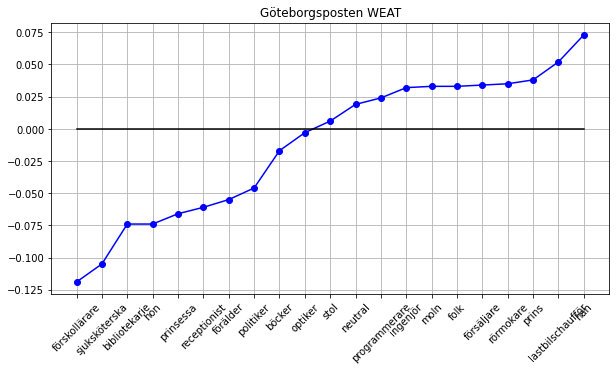

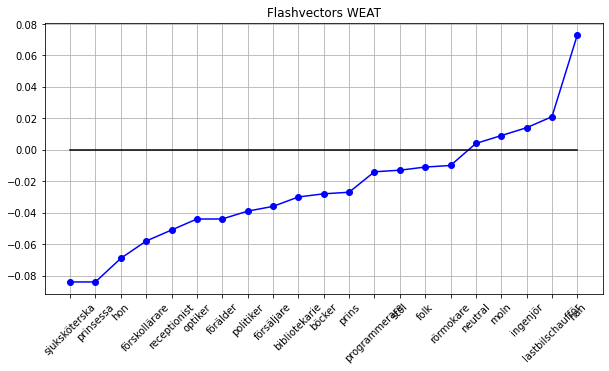

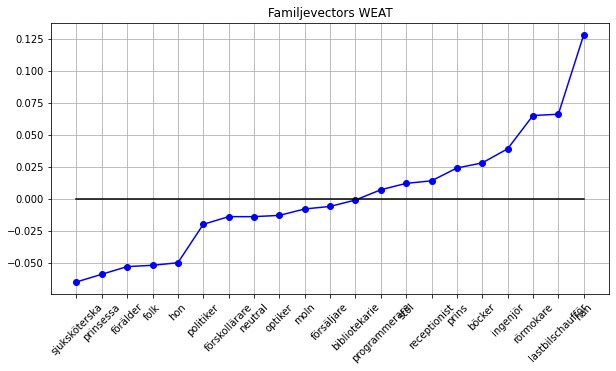

In [16]:
for name in ["swectors", "flashvectors","familjevectors"]:
    
    ripa_values[name].sort(key=lambda x: x[1])
    weat_values[name].sort(key=lambda x: x[1])
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(5)
    words, weat_numbers = zip(*weat_values[name])
    #words, ripa_numbers = zip(*ripa_values[name])
    #plt.plot(words, ripa_numbers, 'r-o')
    plt.plot(words, weat_numbers, 'b-o')
    plt.plot(words, [0 for w in words], 'black')
    plt.xticks(rotation=45)
    if name == 'swectors':
        plt.title(f"Göteborgsposten WEAT")
    else:
        plt.title(f"{name.capitalize()} WEAT")
    plt.grid(True)
    plt.show()